In [1]:
import sys
import yaml
import pyart
import joblib
import numpy as np
import pandas as pd
from analysis import *
import scipy.stats as ss
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../scripts')
import core


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Model variances

In [2]:
win=100
nbasis=15
exp = 'nat8a'
stim_info = pd.read_csv(f"../inputs/stimuli/{exp}-info.csv")
spectrograms = pd.read_csv(f"../build/{exp}/spectrograms.csv", index_col=[0,1])
motifs = stim_info.motif.unique()
gap = stim_info[stim_info.type=='gap'].groupby(['motif','gap']).first()[['gap_start', 'gap_stop']]
with open(f"../inputs/nat8-familiarity-coding.yml") as famfile:
    familiarity = yaml.safe_load(famfile)

In [3]:
variances = {}
for dataset in ['alpha','178B', '180B', 'beta']:
    models = joblib.load(f"../output/{exp}/{dataset}_PLS_models.pkl")
    variances[dataset] = pd.DataFrame(models['variances'])
    print(f"Exp {exp} dataset {dataset} mean %variance explained at 6 components:",
          pd.DataFrame(models['variances']).T.mean().loc[11]*100,
         )
    print(f"Exp {exp} dataset {dataset} std %variance explained at 6 components:",
          pd.DataFrame(models['variances']).T.std().loc[11]*100,
         )

Exp nat8a dataset alpha mean %variance explained at 6 components: 7.545376519079447
Exp nat8a dataset alpha std %variance explained at 6 components: 0.6548318903171056
Exp nat8a dataset 178B mean %variance explained at 6 components: 8.838959481912214
Exp nat8a dataset 178B std %variance explained at 6 components: 1.171637305127786
Exp nat8a dataset 180B mean %variance explained at 6 components: 7.630673192132201
Exp nat8a dataset 180B std %variance explained at 6 components: 0.6154726227507454
Exp nat8a dataset beta mean %variance explained at 6 components: 7.966628188781708
Exp nat8a dataset beta std %variance explained at 6 components: 0.5723343661385006


# Aggregate distances across dataset

In [4]:
scores = pd.read_csv(
   "../output/nat8a/distances-nat8a.csv",
    index_col=0
).set_index(['fam','motif','gap','comp'])
scores.head()

score
fam      motif gap comp          
familiar B189  1.0 GBCB  0.214145
                   GBC   1.303263
                   GBN   0.580108
               2.0 GBCB  0.178069
                   GBC   0.781890

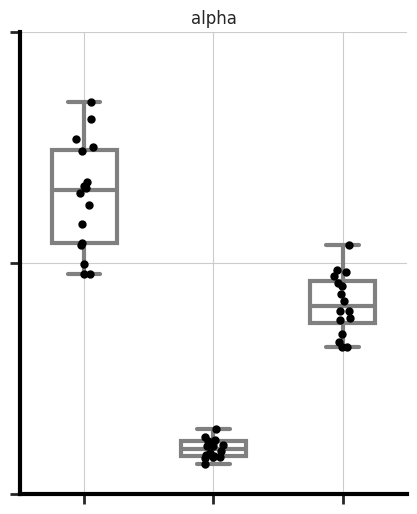

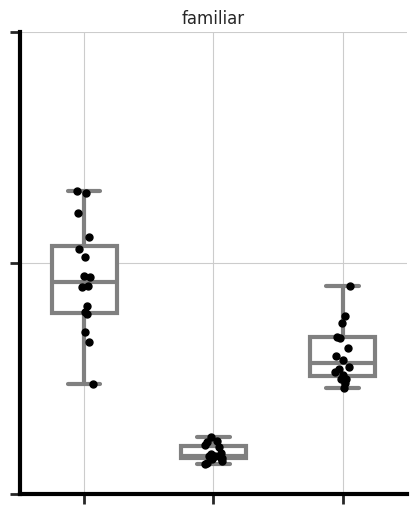

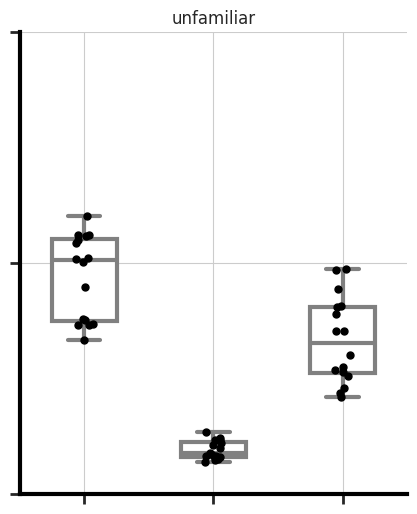

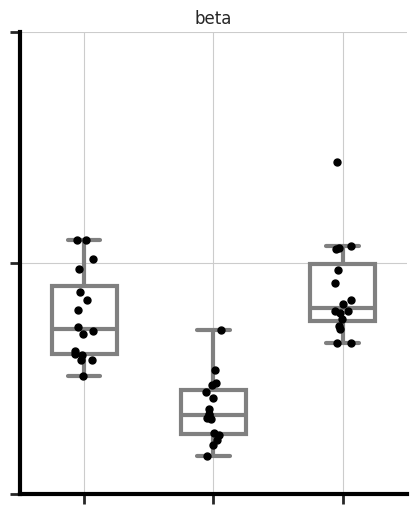

In [5]:
sns.set_style('whitegrid')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1

plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

for i, c in enumerate(['alpha','familiar', 'unfamiliar', 'beta']):
    
    ax = plt.figure(figsize=(5,6)).add_subplot()
    dim = 11

    dt = scores.loc[c].unstack('comp').droplevel(0,axis=1)
    bp = ax.boxplot(
        dt[['GBC', 'GBCB', 'GBN']],
        showfliers=False,
        patch_artist=True,
        positions = [0,1,2],
        widths=0.5
    )
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='grey', lw=3)
    
    for patch in bp['boxes']:
        patch.set(facecolor='white')

    for icd, cd in enumerate(['GBC', 'GBCB', 'GBN']):
        ax.plot(
            np.repeat(icd, 16) + np.random.uniform(-0.07,0.07,16),
            dt[cd], marker='o', markersize=5,
            ls='', color='black',
            zorder=10
        )

        
    ax.set_xlim(-0.5, 2.5)
    ax.set_xticks([0,1,2], [])
    ax.set_yticks([0,1,2], [])
    ax.set_ylim(0,2)
    ax.set_title(c)
    plt.setp(ax.spines.values(), lw=3, color='black');
    sns.despine(ax=ax, top=True, right=True)